# Predicting EUR/USD Outcomes Using LSTMs

The dataset used is EUR/USD OHLC data over a 15 minute timeframe, spanning from October 2002 to October 2023. The goal is to predict the OHLC prices 3 timesteps in advance (I.E. 45 minutes in advance).

The architecture that I'll be using for this are stacked LSTMs in a relatively light and linear model, due to time and computational constraints. Potential improvements for the future are listed at the end of this notebook.

In [1]:
import numpy as np 
import pandas as pd 
from keras.models import Sequential
from keras.layers import SimpleRNN, Flatten, TimeDistributed, LSTM, Dense
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping
import plotly.graph_objects as go
from matplotlib import pyplot as plt
from random import randint

keras.utils.set_random_seed(7)

In [2]:
# Check if GPU is being used

from tensorflow.python.keras import backend as K
K._get_available_gpus()

[]

# Data Loading and Cleaning

As mentioned previously, the data provided is for EUR/USD Forex pairs over a 15 minute timeframe, spanning from October 2002, to October 2023. 

While the data is relatively clean, there is some extra preprocessing that needs to be done before it can be utilized.

In [3]:
# Load raw CSV file
filepath = './data/eurusd-15m.csv'

df = pd.read_csv(filepath, delimiter=';')
df.head()    # Preview data

,21/10/2002,01:15:00,0.9732,0.9734,0.9726,0.9726.1,0
0,21/10/2002,01:30:00,0.97260,0.97275,0.97195,0.97205,0
1,21/10/2002,01:45:00,0.97215,0.97235,0.97195,0.97210,0
2,21/10/2002,02:00:00,0.97200,0.97260,0.97190,0.97240,0
3,21/10/2002,02:15:00,0.97235,0.97250,0.97220,0.97225,0
4,21/10/2002,02:30:00,0.97230,0.97245,0.97190,0.97195,0


In [4]:
# The columns have no names and must be added.
df.columns = ['date', 'time', 'open', 'high', 'low', 'close', 'vol']

# Additionally, the "vol" column will not play a role in our model prediction, and will be dropped
df.drop('vol', axis=1, inplace=True)

# Preview data again
df.head()

,date,time,open,high,low,close
0,21/10/2002,01:30:00,0.97260,0.97275,0.97195,0.97205
1,21/10/2002,01:45:00,0.97215,0.97235,0.97195,0.97210
2,21/10/2002,02:00:00,0.97200,0.97260,0.97190,0.97240
3,21/10/2002,02:15:00,0.97235,0.97250,0.97220,0.97225
4,21/10/2002,02:30:00,0.97230,0.97245,0.97190,0.97195


In [5]:
# Fixing date & time columns such that they're merged into a single column of type datetime

## Merge the two columns
df['time'] = df['time'].astype('str')
df['date'] = df['date'].astype('str')

df['datetime'] = df['date'] + "-" + df['time']

## Drop the original columns
df.drop(['date', 'time'], inplace=True, axis=1)

## Convert the datetime column to a a column of *type* datetime
df['datetime'] = pd.to_datetime(df['datetime'],
               format='%d/%m/%Y-%H:%M:%S')

## Preview dataframe again
df.head()

,open,high,low,close,datetime
0,0.97260,0.97275,0.97195,0.97205,2002-10-21 01:30:00
1,0.97215,0.97235,0.97195,0.97210,2002-10-21 01:45:00
2,0.97200,0.97260,0.97190,0.97240,2002-10-21 02:00:00
3,0.97235,0.97250,0.97220,0.97225,2002-10-21 02:15:00
4,0.97230,0.97245,0.97190,0.97195,2002-10-21 02:30:00


Here, I'll preview the data using a candlestick chart. Here are the first 50 timesteps:

In [6]:
timestep = 50

fig = go.Figure(data=[
    go.Candlestick(open=df['open'][:timestep], high=df['high'][:timestep],
    low=df['low'][:timestep], close=df['close'][:timestep]
    )
])
            
fig.update_layout(xaxis_rangeslider_visible=False)
fig.show()

Here are the last 50 timesteps:

In [7]:
timestep = -50

fig = go.Figure(data=[
    go.Candlestick(open=df['open'][timestep:], high=df['high'][timestep:],
    low=df['low'][timestep:], close=df['close'][timestep:]
    )
])
            
fig.update_layout(xaxis_rangeslider_visible=False)
fig.show()

# Model Building

Here, I'll define the parameters that'll dictate model architecture. Two specific parameters are of importance here:
- `LOOK_BACK`: How many timesteps into the past will the model recieve as input. For instance, if `LOOK_BACK` is 25, the model will be fed 25 timesteps in the past simultaneously.
- `LOOK_FORWARD`: How many timesteps into the future will the model output as a prediction. For instance, if `LOOK_FORWARD` is 3, then the model will output 3 OHLC data for 3 timesteps into the future. 

Additionally, I'll be setting aside 5% of the data for validation. Given that our dataset is relatively large, 5% is more than enough to be able to illustrate our model's performance on unseen data. 

In [8]:
# Model parameters

N_FEATURES = 4
LOOK_BACK = 25
LOOK_FORWARD = 3
LEARNING_RATE = 0.0001

N_EPOCHS = 200
BATCH_SIZE = 250
VALIDATION_SIZE = 0.05
N_UNITS = 128

model_dir = './models/'
model_name = "baseline.keras"


In [9]:
# convert an array of values into a dataset matrix
def create_dataset_x(dataset, look_back, look_forward):
    data = []
    for i in range(look_back, len(dataset)-look_forward-1):
        a = dataset[i-look_back:i]
        data.append(a)
    return np.array(data)

def create_dataset_y(dataset, look_back, look_forward):
    data = []
    for i in range(look_back, len(dataset)-look_forward-1):
        a = dataset[i:(i+look_forward)]
        data.append(a)
    return np.array(data)

In [10]:
# Prep data
X = df.drop('datetime', axis=1)
Y = df.drop('datetime', axis=1)

# Make train/validation
data_x = create_dataset_x(X.values.reshape((-1, 4)), LOOK_BACK, LOOK_FORWARD)
print("X data created")

data_y = create_dataset_y(Y, LOOK_BACK, LOOK_FORWARD)
data_y = data_y.reshape(-1, N_FEATURES*LOOK_FORWARD)
print("Y data created")

test_idx = int(data_x.shape[0] * VALIDATION_SIZE)

train_x, val_x = data_x[:test_idx], data_x[test_idx:]
train_y, val_y = data_y[:test_idx], data_y[test_idx:]

X data created
Y data created


As briefly mentioned above, the architecture that will be used is a *stacked LSTM* model.

LSTMS are a type of recurrent neural networks specifically designed to handle long-term dependencies, which means that they can capture patterns and dependencies in sequences. LSTMs also perform implicit feature extraction, meaning they can automatically learn and extract important features from the input sequences without requiring explicit feature engineering. This makes this specifc type of network particularly useful when dealing with complex data such as Forex prices.

Stacking LSTMS comes with a number of benefits, including increased model capacity and improved representation learning for capturing higher-level temporal patterns.

In [11]:
# Define model architecture
model = Sequential()

model.add(LSTM(units=N_UNITS, return_sequences=True, input_shape=(LOOK_BACK, N_FEATURES)))  # LSTM layer with input shape (batch_size, timesteps, input_dim)

# model.add(LSTM(units=N_UNITS*2, return_sequences=True)) 

model.add(LSTM(units=N_UNITS, return_sequences=False))  # Stacked LSTM layer

# Output layer
model.add(Dense(units=N_FEATURES*LOOK_FORWARD))

# Compile model
opt = keras.optimizers.Adam(learning_rate=LEARNING_RATE)
model.compile(optimizer=opt, loss='mse')

# Print model summary
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 25, 128)           68096     
                                                                 
 lstm_1 (LSTM)               (None, 128)               131584    
                                                                 
 dense (Dense)               (None, 12)                1548      
                                                                 
Total params: 201228 (786.05 KB)
Trainable params: 201228 (786.05 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [12]:
# Set model to train

earlystop_cb = EarlyStopping(monitor="val_loss", patience=3)    # Implementing early stopping so if the model training ends early, keras will automatically stops fitting the model for further epochs

history = model.fit(
    train_x, 
    train_y, 
    epochs=N_EPOCHS, 
    batch_size=BATCH_SIZE, 
    verbose=2,
    validation_data=(val_x, val_y),
)

Epoch 1/200

107/107 - 85s - loss: 0.1986 - val_loss: 0.0157 - 85s/epoch - 790ms/step
Epoch 2/200
107/107 - 84s - loss: 0.0011 - val_loss: 0.0143 - 84s/epoch - 784ms/step
Epoch 3/200
107/107 - 82s - loss: 9.0722e-04 - val_loss: 0.0122 - 82s/epoch - 769ms/step
Epoch 4/200
107/107 - 82s - loss: 7.3298e-04 - val_loss: 0.0101 - 82s/epoch - 766ms/step
Epoch 5/200
107/107 - 82s - loss: 5.5644e-04 - val_loss: 0.0080 - 82s/epoch - 762ms/step
Epoch 6/200
107/107 - 81s - loss: 3.9243e-04 - val_loss: 0.0062 - 81s/epoch - 759ms/step
Epoch 7/200
107/107 - 81s - loss: 2.5398e-04 - val_loss: 0.0045 - 81s/epoch - 756ms/step
Epoch 8/200
107/107 - 81s - loss: 1.4937e-04 - val_loss: 0.0030 - 81s/epoch - 756ms/step
Epoch 9/200
107/107 - 81s - loss: 8.0404e-05 - val_loss: 0.0021 - 81s/epoch - 759ms/step
Epoch 10/200
107/107 - 81s - loss: 4.1265e-05 - val_loss: 0.0015 - 81s/epoch - 756ms/step
Epoch 11/200
107/107 - 81s - loss: 2.2095e-05 - val_loss: 0.0011 - 81s/epoch - 757ms/step
Epoch 12/200
107/107 - 81s

# Evaluating Model Performance 

We can now test the model performance on validation data (never seen before data). First, I'll draw the candlestick chart for model predictions, then I'll 

In [53]:
test_idx = 1

# Get model prediction 
test_x = val_x[test_idx].reshape(-1, 25, 4)
prediction = model.predict(test_x)

# Reshape model prediction such that it can be used for candlestick charts
prediction = prediction.reshape(-1, LOOK_FORWARD, N_FEATURES)

# Join previous timesteps with new future timesteps
final_prediction = np.concatenate((test_x, prediction), axis=1)[0]

1/1 [==============================] - 0s 18ms/step


In [54]:
fig = go.Figure(data=[
    go.Candlestick(open=final_prediction[:, 0], high=final_prediction[:, 1],
    low=final_prediction[:, 2], close=final_prediction[:, 3]
    )
])
            
fig.update_layout(xaxis_rangeslider_visible=False)
fig.show()

In [55]:
# Compare with true values
test_y = val_y[test_idx].reshape(-1, LOOK_FORWARD, N_FEATURES)

true_ohlc = np.concatenate((test_x, test_y), axis=1)[0]

fig = go.Figure(data=[
    go.Candlestick(open=true_ohlc[:, 0], high=true_ohlc[:, 1],
    low=true_ohlc[:, 2], close=true_ohlc[:, 3]
    )
])
            
fig.update_layout(xaxis_rangeslider_visible=False)
fig.show()

The last three candlesticks between these two charts are roughly similar, meaning that the model had learned to predict the general trend given the input data, but, the model was not able to learn candle shapes as well as it could've. A solution to this is proposed in the final part of this notebook.

__However, this error is nigh negligible, as errors are on the scale of 0.001.__


Juding from the validation/training loss plot below, we can learn that if this model had more time to train, it would most likely perform even better:

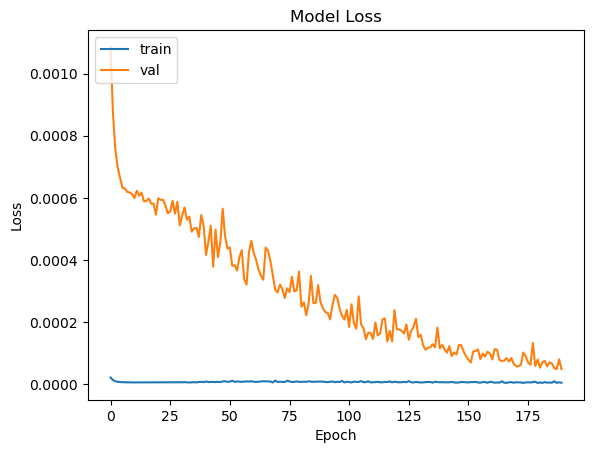

In [25]:
# Plot validation/training error
plt.plot(history.history['loss'][10:])     # Plotting from the 10th epoch onwards, since the drop from the first few epochs was too drastic and changes the scale of the entire plot
plt.plot(history.history['val_loss'][10:])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

As you can see, while the changes in training loss were somewhat negligible, over time, validation loss continued to decrease, implying that the model was still continuing to learn from it's previous mistakes. However, the validation loss  had not plateaued, meaning there was still room for improvement had there been more time.

Finally, I'll save the model so that it can be reloaded later for future predictions.

In [17]:
model.save(model_dir + model_name)
print("Model saved!")

Model saved!


The model can be easily reloaded via the following command:

```
from keras.models import load_model

model = load_model(model_dir + model_name)
```

# Future Steps

Improvements for the future include:
- Testing normalization, wavelet denoising and other various denoising techniques to improve model accuracy over time
- Using various technical indicators to feed more insight and information to the model.
- Defining a custom loss function and/or features that'll take the candle *shape* into account.
- Predicting trends rather than prices over time, for a more reliable, long-term model that will be more profitable over time.